In [1]:
import csv
from collections import defaultdict
from constants import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
valid_users = set()
user_train_count = defaultdict(int)     # number of training grids completed for each user
user_test_count = defaultdict(int)      # number of test grids completed for each user
user_test_score = defaultdict(int)     # cumulative training score for each user
user_test_timeouts = defaultdict(set)   # number of timeouts on test grids for each user
user_condition = defaultdict(int)       # whether user was assigned to complete training or not

with open('data/training_experiment_raw.csv', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        user = row['userid']
        valid_users.add(user)
        if row['step'] == '6':          # step 6 contains metadata for the whole trial such as total reward
            user_condition[user] = row['training'] == '1'
            if row['type'] == "train":
                user_train_count[user] += 1
            elif row['type'] == "test":
                user_test_count[user] += 1
                user_test_score[user] += int(row['reward_cum'])
            if row['timeout'] == '1':
                user_test_timeouts[user].add(int(row['gridnum']))

# exclude users who did not complete all training and test grids, scored less than -35 points in test, or timed out 6 or more times
def include_user(user):
    include_user = True
    user_timeouts = user_test_timeouts[user]
    if user_test_score[user]<-35 or user_test_count[user]!=24:
        include_user = False
    if len([x for x in user_timeouts if 100<x<200])>=2 or len([x for x in user_timeouts if 200<x<300])>=2:
        include_user = False
    if user_condition[user] == True and (user_train_count[user]!=60):
        include_user = False
    return include_user


print("Number of users before exclusions: " + str(len(valid_users)))       
valid_users = set(filter(include_user, valid_users))
print("Number of users after exclusions: " + str(len(valid_users)))

Number of users before exclusions: 645
Number of users after exclusions: 398


In [11]:
df = pd.read_csv('data/training_experiment_raw.csv', encoding='utf-8-sig') 
df['userid'] = df['userid'].apply(str)
filtered = df[(df['userid'].isin(valid_users))]
filtered = filtered[(filtered['step']==6) & (filtered['type']=='train')]
filtered['correct'] = filtered['reward_cum'] == filtered['reward_max']
filtered['trial_group'] = (filtered['trialnum'] - 1) // 10
training_accuracy = filtered.groupby('userid')['correct'].mean()
mean_training_accuracy = training_accuracy.mean()
sem_training_accuracy = training_accuracy.sem()
print(f"Mean training accuracy: {mean_training_accuracy:.1%}")
print(f"SEM training accuracy: {sem_training_accuracy:.1%}")

Mean training accuracy: 71.8%
SEM training accuracy: 0.9%


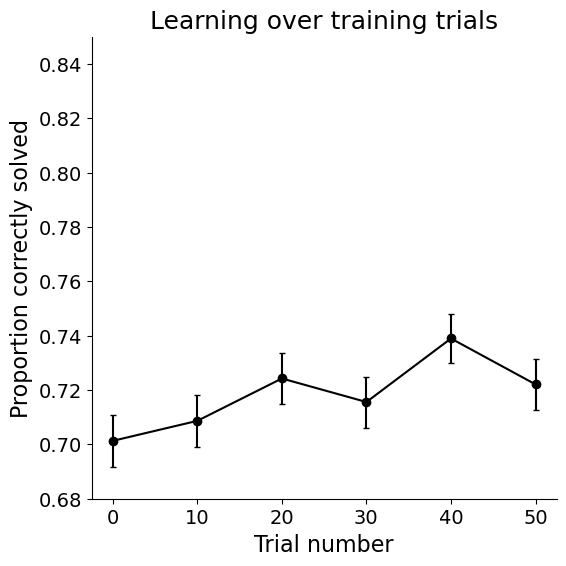

In [19]:
# Group every 5 trials to smooth the graph
plt.rcParams.update({'font.size': 14, 'figure.figsize': (6, 6), 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14, 'legend.title_fontsize': 16})
# Calculate mean and standard error of the mean for each trial group
mean_correct_grouped = filtered.groupby('trial_group')['correct'].mean()
sem_correct_grouped = filtered.groupby('trial_group')['correct'].sem()

# Plot the average correct over trial groups with error bars
plt.errorbar(mean_correct_grouped.index * 10, mean_correct_grouped, yerr=sem_correct_grouped, marker='o', color='black',capsize=2)
plt.xlabel('Trial number')
plt.ylabel('Proportion correctly solved')
plt.ylim(.68,.85)
plt.title('Learning over training trials')

# Remove grid background and top and right spines
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [3]:
best_score_count = defaultdict(int)     # The number of grids where the user achieved the best score for each grid type and manipulation
total_count = defaultdict(int)          # The total number of grids completed for each grid type and manipulation
data = []

with open('data/training_experiment_raw.csv', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        gridnum = int(row['gridnum'])
        userid = row['userid']
        # looks only at final results for test grids of interest where user did not time out
        if  (gridnum in MUST_PUSH_GRIDNUMS or gridnum in MUST_SWITCH_GRIDNUMS) and userid in valid_users and not gridnum in user_test_timeouts[userid] and row['step']=='6':
            score_dif = int(row['reward_cum'])-int(row['reward_max'])
            training = user_condition[userid]
            push_val = None
            if training == True:
                train = 0.5 
            else:
                train = -0.5 
            if gridnum in MUST_PUSH_GRIDNUMS: 
                push_val = 0.5
            elif gridnum in MUST_SWITCH_GRIDNUMS:
                push_val = -0.5
           
            bin_num = (gridnum//100-1)*2 + int(training)  # assign a bin for each unique gridtype and time constraint combination
            if score_dif == 0:
                best_score_count[bin_num] += 1
            total_count[bin_num] += 1
            data.append([score_dif, userid, gridnum, push_val, train*push_val, train])

df = pd.DataFrame(data,columns=['score_dif', 'user_id', 'grid_num', 'push', 'train_x_push', 'train'])
df.to_csv('data/training_data_coded.csv')

defaultdict(<class 'int'>, {2: 243, 0: 67, 1: 106, 3: 432})


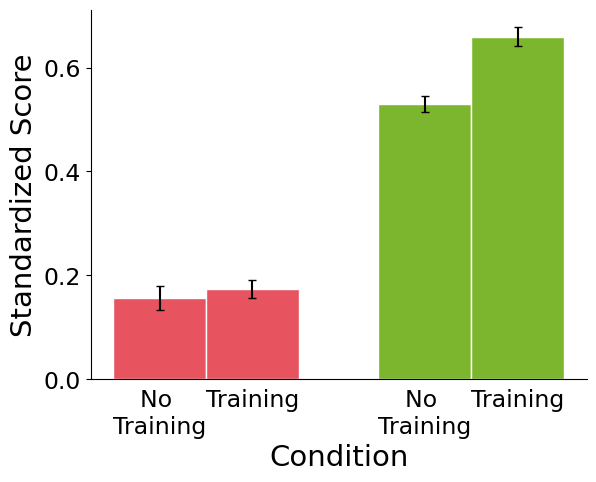

In [11]:
# Compute proportion of grids on which the best score was achieved 
print(best_score_count)
proportion = {}
for bin_num, count in best_score_count.items():
    proportion[bin_num] = count/total_count[bin_num]

# Compute standard error of mean
sem = []
for bin_num, count in best_score_count.items():
    x = np.concatenate((np.zeros(total_count[bin_num]-count),np.ones(count)))
    sem.append(scipy.stats.sem(x))

# Define labels, positions, bar heights and error bar heights
labels = ['No \nTraining', 'Training', 'No \nTraining', 'Training']
notrain_proportions = []
notrain_error = []
train_proportions = []
train_error = []

for i in range(4):
    if i%2==0:
        notrain_proportions.append(proportion[i])
        notrain_error.append(sem[i])
    else:
        train_proportions.append(proportion[i])
        train_error.append(sem[i])

x = np.arange(2)  # the label locations
width = 0.35  # the width of the bars
color=['#E7545F', '#7CB62F']
plt.rcParams.update({'font.size': 21})

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, notrain_proportions, width, yerr=notrain_error, capsize=3, color=color, edgecolor='white')
rects2 = ax.bar(x + width/2, train_proportions, width, yerr=train_error, capsize=3, color=color,  edgecolor='white')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Standardized Score')
ax.set_xticks(np.array([-.175,0.175,.825,1.175]))
ax.set_xticklabels(labels)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
ax.set_xlabel('Condition')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.tick_params(
    axis='both',         
    which='both',     
    bottom=False)
plt.show()

In [13]:
labels = ['Push','Switch']
for idx, p in enumerate(notrain_proportions):
    print("No Training " + labels[idx] + ": " + '{:.1%}'.format(p) + " ± " + '{:.1%}'.format(notrain_error[idx]))
for idx, p in enumerate(train_proportions):
    print("Training " + labels[idx] + ": " + '{:.1%}'.format(p) + " ± " + '{:.1%}'.format(train_error[idx]))

No Training Push: 15.6% ± 2.3%
No Training Switch: 53.1% ± 1.5%
Training Push: 17.4% ± 1.8%
Training Switch: 66.0% ± 1.9%
